<a href="https://colab.research.google.com/github/mathchou/CSC485-Sp24/blob/cfitz/phishingproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sklearn as sk
import matplotlib
import tensorflow as tf
import pandas as pd
import csv as csv
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ph = pd.read_csv('/content/dataset_link_phishing.csv')
print(ph)

       Unnamed: 0                                                url  \
0               0     http://www.progarchives.com/album.asp?id=61737   
1               1  http://signin.eday.co.uk.ws.edayisapi.dllsign....   
2               2  http://www.avevaconstruction.com/blesstool/ima...   
3               3                              http://www.jp519.com/   
4               4                       https://www.velocidrone.com/   
...           ...                                                ...   
19426       11425      http://www.fontspace.com/category/blackletter   
19427       11426  http://www.budgetbots.com/server.php/Server%20...   
19428       11427  https://www.facebook.com/Interactive-Televisio...   
19429       11428             http://www.mypublicdomainpictures.com/   
19430       11429  http://174.139.46.123/ap/signin?openid.pape.ma...   

       url_length  hostname_length  ip  total_of.  total_of-  total_of@  \
0              46               20   0          3          0

<ipython-input-2-c1f1b7a20059>:1: DtypeWarning: Columns (78) have mixed types. Specify dtype option on import or set low_memory=False.
  ph = pd.read_csv('/content/dataset_link_phishing.csv')


In [3]:
ph.columns

Index(['Unnamed: 0', 'url', 'url_length', 'hostname_length', 'ip', 'total_of.',
       'total_of-', 'total_of@', 'total_of?', 'total_of&', 'total_of=',
       'total_of_', 'total_of~', 'total_of%', 'total_of/', 'total_of*',
       'total_of:', 'total_of,', 'total_of;', 'total_of$', 'total_of_www',
       'total_of_com', 'total_of_http_in_path', 'https_token',
       'ratio_digits_url', 'ratio_digits_host', 'punycode', 'port',
       'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain',
       'nb_subdomains', 'prefix_suffix', 'random_domain', 'shortening_service',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       'statist

In [4]:
ph.head()

Unnamed: 0                                                url  url_length  \
0           0     http://www.progarchives.com/album.asp?id=61737          46   
1           1  http://signin.eday.co.uk.ws.edayisapi.dllsign....         128   
2           2  http://www.avevaconstruction.com/blesstool/ima...          52   
3           3                              http://www.jp519.com/          21   
4           4                       https://www.velocidrone.com/          28   

   hostname_length  ip  total_of.  total_of-  total_of@  total_of?  total_of&  \
0               20   0          3          0          0          1          0   
1              120   0         10          0          0          0          0   
2               25   0          3          0          0          0          0   
3               13   0          2          0          0          0          0   
4               19   0          2          0          0          0          0   

   ...  domain_in_title  domain_with_copyright  whois_registered_domain  \
0  ...                1                    one                        0   
1  ...                1                   zero                        0   
2  ...                1                   zero                        0   
3  ...                1                    one                        0   
4  ...                0                   zero                        0   

   domain_registration_length  domain_age  web_traffic  dns_record  \
0                         627        6678        78526           0   
1                         300          65            0           0   
2                         119        1707            0           0   
3                         130        1331            0           0   
4                         164        1662       312044           0   

   google_index  page_rank      status  
0             0          5    phishing  
1             1          0    phishing  
2             1          0    phishing  
3             0          0  legitimate  
4             0          4  legitimate  

[5 rows x 87 columns]

In [5]:
# Checking for missing values
missing_values = ph.isnull().sum()

# Filtering out columns that have missing values
missing_values[missing_values > 0]


Series([], dtype: int64)

In [6]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Initialize the label encoder for categorical data transformation
label_encoder = LabelEncoder()

# Encode the 'status' column to transform categories into numbers
# This is necessary because machine learning models require numerical input.
# Here, 'phishing' and 'legitimate' statuses in the dataset are converted to numeric values.
ph['status_encoded'] = label_encoder.fit_transform(ph['status'])

# Initialize the Min-Max Scaler for numerical data normalization
min_max_scaler = MinMaxScaler()

# Select numerical features that will be normalized
# Normalization adjusts the scale of numerical features so each feature contributes equally to model training.
# It prevents features with larger values from disproportionately influencing the model.
numerical_features = ['url_length', 'web_traffic']

# Apply Min-Max Scaling to normalize the selected features to a range between 0 and 1.
# The formula used for Min-Max Scaling is (X - X_min) / (X_max - X_min).
# This is crucial for distance-based algorithms and helps in faster convergence of gradient descent-based algorithms.
ph[numerical_features] = min_max_scaler.fit_transform(ph[numerical_features])

# Display the first few rows to verify the changes
# The 'status_encoded' column now contains numeric representations of the original 'status' text values.
# The 'url_length' and 'web_traffic' features have been scaled to a range between 0 and 1.
ph[['status', 'status_encoded', 'url_length', 'web_traffic']].head()


status  status_encoded  url_length  web_traffic
0    phishing               1    0.020872     0.007293
1    phishing               1    0.071209     0.000000
2    phishing               1    0.024555     0.000000
3  legitimate               0    0.005525     0.000000
4  legitimate               0    0.009822     0.028979

In [7]:
# Identifying outliers using the IQR method for 'url_length' and 'web_traffic'

# Calculate IQR for 'url_length'
Q1_url_length = ph['url_length'].quantile(0.25)
Q3_url_length = ph['url_length'].quantile(0.75)
IQR_url_length = Q3_url_length - Q1_url_length

# Calculate the bounds for outliers
lower_bound_url_length = Q1_url_length - 1.5 * IQR_url_length
upper_bound_url_length = Q3_url_length + 1.5 * IQR_url_length

# Calculate IQR for 'web_traffic'
Q1_web_traffic = ph['web_traffic'].quantile(0.25)
Q3_web_traffic = ph['web_traffic'].quantile(0.75)
IQR_web_traffic = Q3_web_traffic - Q1_web_traffic

# Calculate the bounds for outliers
lower_bound_web_traffic = Q1_web_traffic - 1.5 * IQR_web_traffic
upper_bound_web_traffic = Q3_web_traffic + 1.5 * IQR_web_traffic

# Determine the number of outliers
outliers_url_length = ph[(ph['url_length'] < lower_bound_url_length) | (ph['url_length'] > upper_bound_url_length)]
outliers_web_traffic = ph[(ph['web_traffic'] < lower_bound_web_traffic) | (ph['web_traffic'] > upper_bound_web_traffic)]

# Check for inconsistencies in 'status' column
status_values = ph['status'].unique()

(outliers_url_length.shape[0], outliers_web_traffic.shape[0], status_values)


(1051, 3648, array(['phishing', 'legitimate'], dtype=object))

In [8]:
ph.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19431 entries, 0 to 19430
Data columns (total 88 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  19431 non-null  int64  
 1   url                         19431 non-null  object 
 2   url_length                  19431 non-null  float64
 3   hostname_length             19431 non-null  int64  
 4   ip                          19431 non-null  int64  
 5   total_of.                   19431 non-null  int64  
 6   total_of-                   19431 non-null  int64  
 7   total_of@                   19431 non-null  int64  
 8   total_of?                   19431 non-null  int64  
 9   total_of&                   19431 non-null  int64  
 10  total_of=                   19431 non-null  int64  
 11  total_of_                   19431 non-null  int64  
 12  total_of~                   19431 non-null  int64  
 13  total_of%                   194

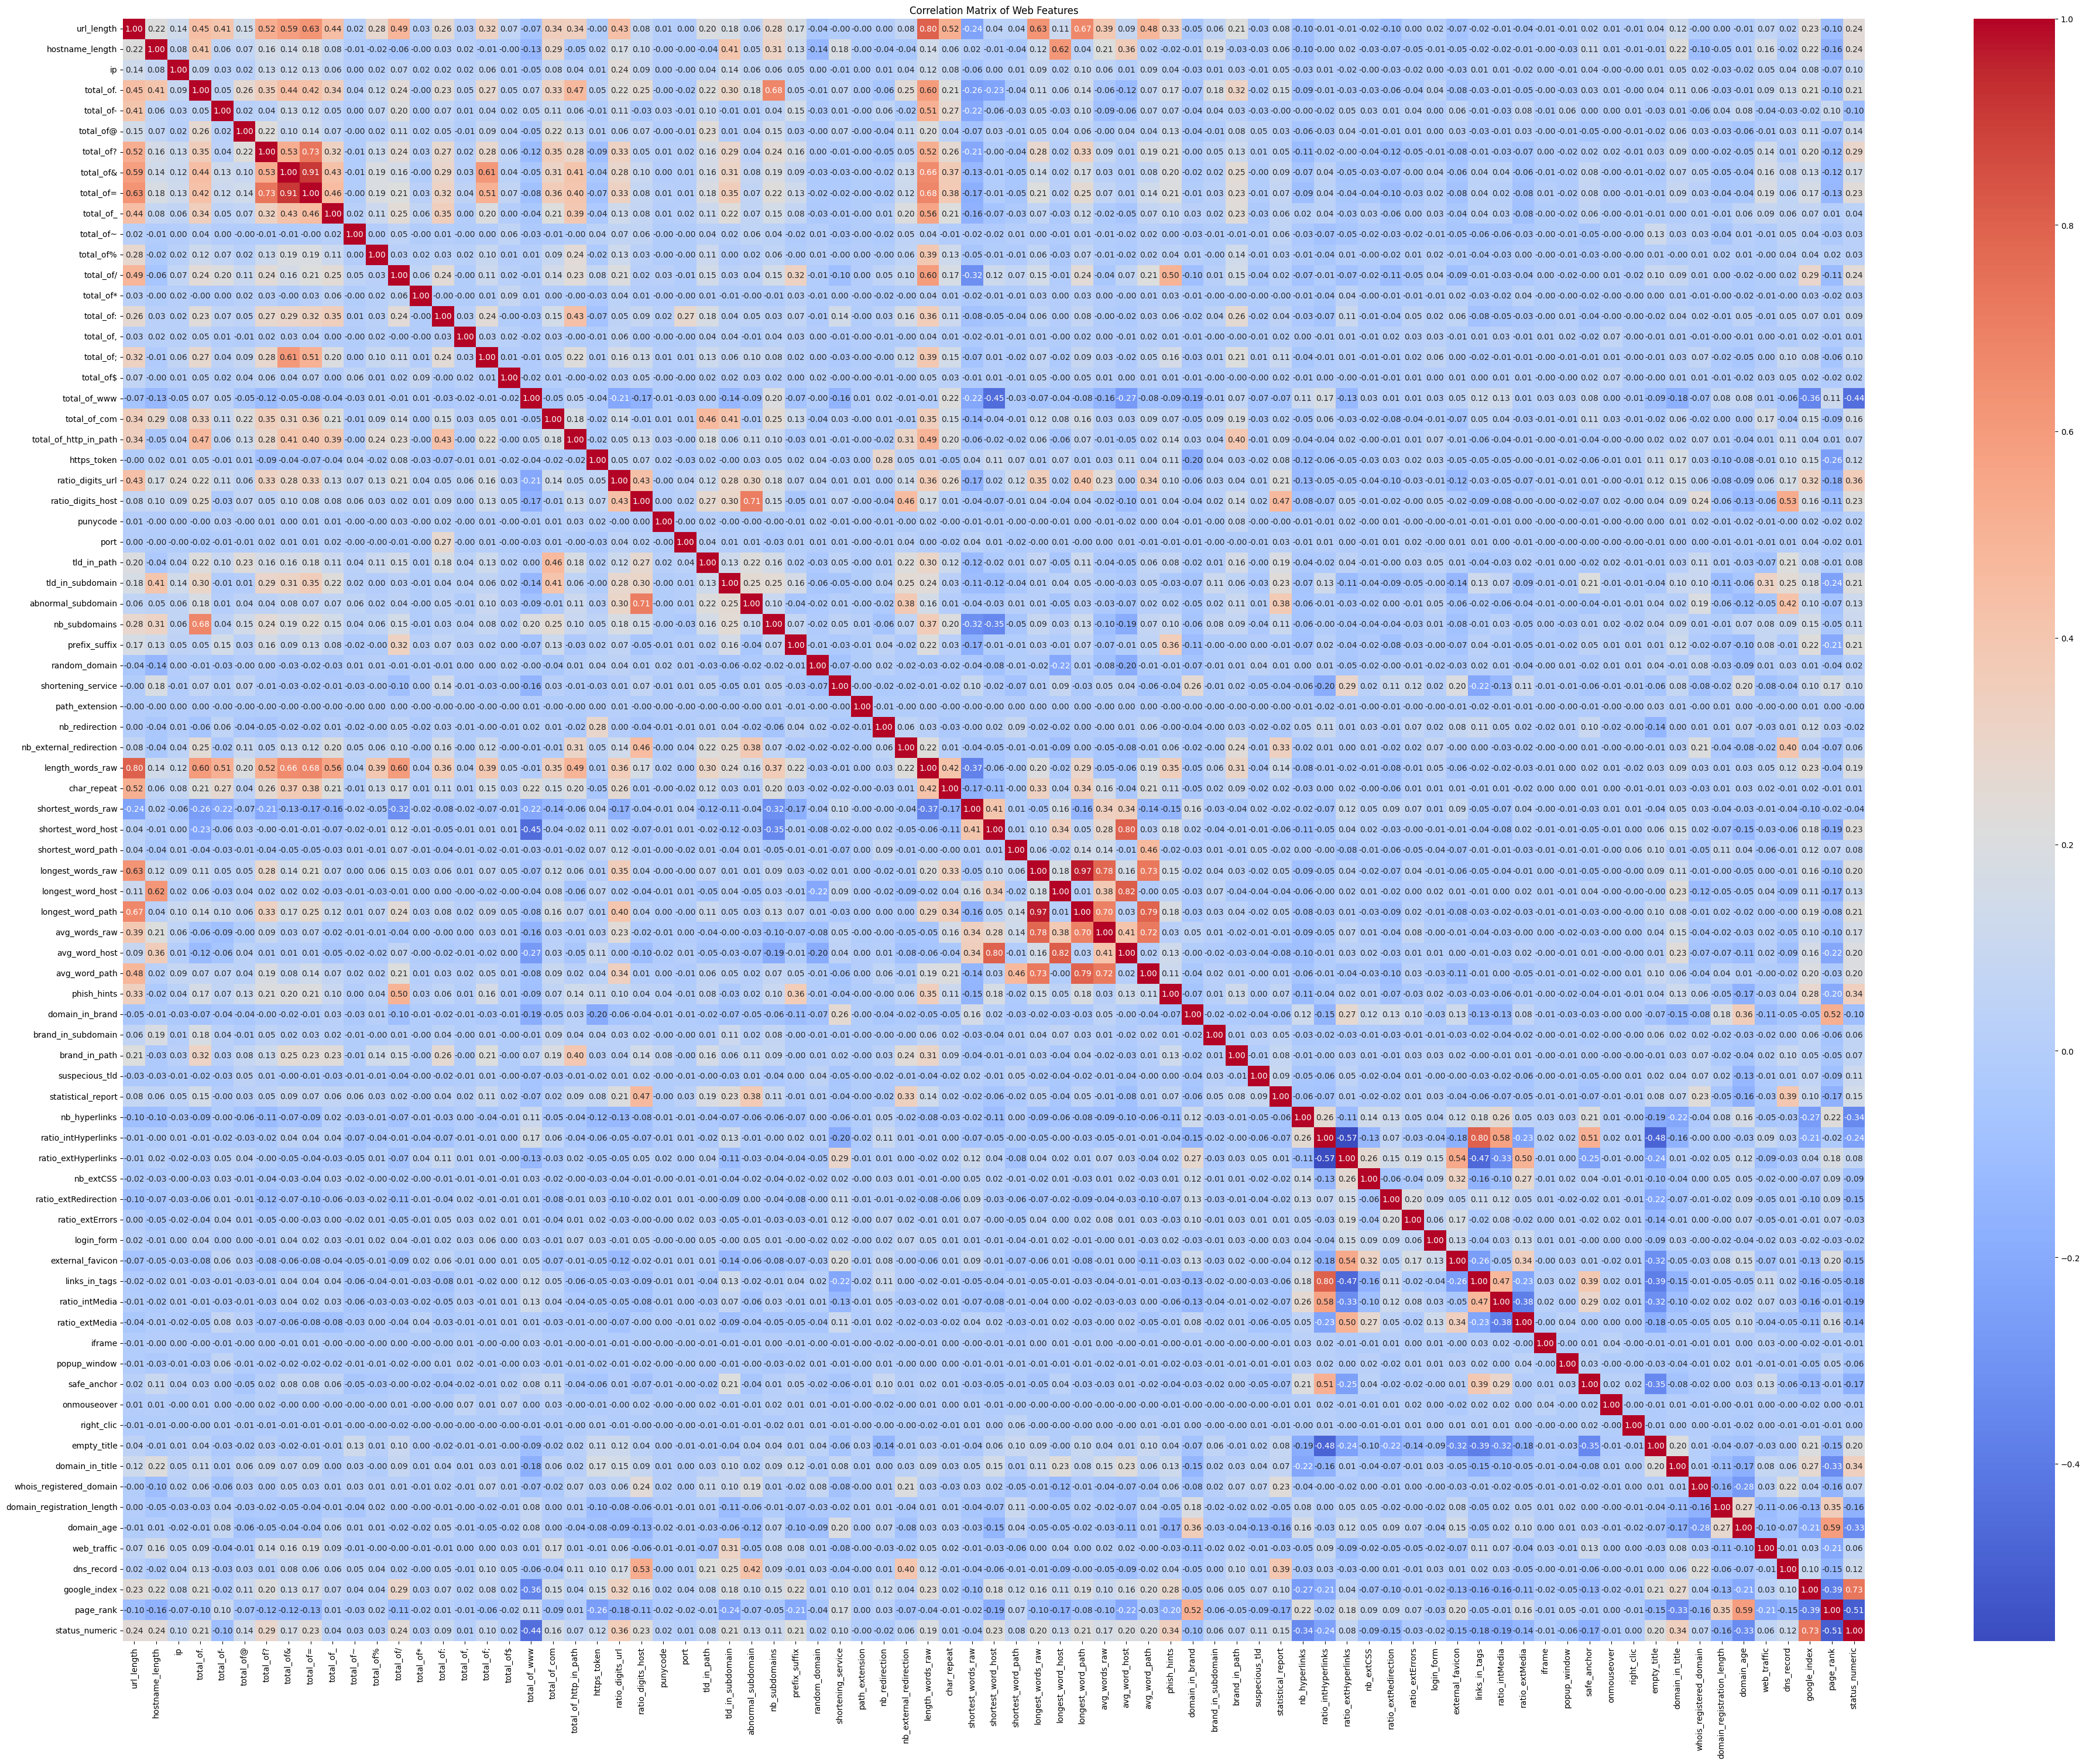

In [9]:
# Correlation matrix for a subset of the dataset
# Selecting a subset of columns for the correlation analysis to keep it interpretable
columns_for_correlation = [
     'url_length', 'hostname_length', 'ip', 'total_of.',
       'total_of-', 'total_of@', 'total_of?', 'total_of&', 'total_of=',
       'total_of_', 'total_of~', 'total_of%', 'total_of/', 'total_of*',
       'total_of:', 'total_of,', 'total_of;', 'total_of$', 'total_of_www',
       'total_of_com', 'total_of_http_in_path', 'https_token',
       'ratio_digits_url', 'ratio_digits_host', 'punycode', 'port',
       'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain',
       'nb_subdomains', 'prefix_suffix', 'random_domain', 'shortening_service',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       'statistical_report', 'nb_hyperlinks', 'ratio_intHyperlinks',
       'ratio_extHyperlinks', 'nb_extCSS', 'ratio_extRedirection',
       'ratio_extErrors', 'login_form', 'external_favicon', 'links_in_tags',
       'ratio_intMedia', 'ratio_extMedia', 'iframe',
       'popup_window', 'safe_anchor', 'onmouseover', 'right_clic',
       'empty_title', 'domain_in_title', 'whois_registered_domain',
        'domain_registration_length', 'domain_age',
       'web_traffic', 'dns_record', 'google_index', 'page_rank',
]

# Adding the 'status' column by mapping 'phishing' to 1 and 'legitimate' to 0
ph['status_numeric'] = ph['status'].map({'phishing': 1, 'legitimate': 0})

# Including the 'status_numeric' column to see how other features correlate with the website being phishing or legitimate
columns_for_correlation.append('status_numeric')

# Calculating the correlation matrix
correlation_matrix = ph[columns_for_correlation].corr()

# Plotting the correlation matrix
plt.figure(figsize=(48, 36))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Web Features')
plt.show()


Streaming output truncated to the last 5000 lines.
Shape of total_of_http_in_path: (19431,), Shape of domain_registration_length: (19431,)
Shape of total_of_http_in_path: (19431,), Shape of domain_age: (19431,)
Shape of total_of_http_in_path: (19431,), Shape of web_traffic: (19431,)
Shape of total_of_http_in_path: (19431,), Shape of dns_record: (19431,)
Shape of total_of_http_in_path: (19431,), Shape of google_index: (19431,)
Shape of total_of_http_in_path: (19431,), Shape of page_rank: (19431,)
Shape of total_of_http_in_path: (19431,), Shape of status_numeric: (38862,)
Error processing total_of_http_in_path vs status_numeric: x and y must have the same length.
Shape of total_of_http_in_path: (19431,), Shape of status_numeric: (38862,)
Error processing total_of_http_in_path vs status_numeric: x and y must have the same length.
Shape of https_token: (19431,), Shape of url_length: (19431,)
Shape of https_token: (19431,), Shape of hostname_length: (19431,)
Shape of https_token: (19431,), 

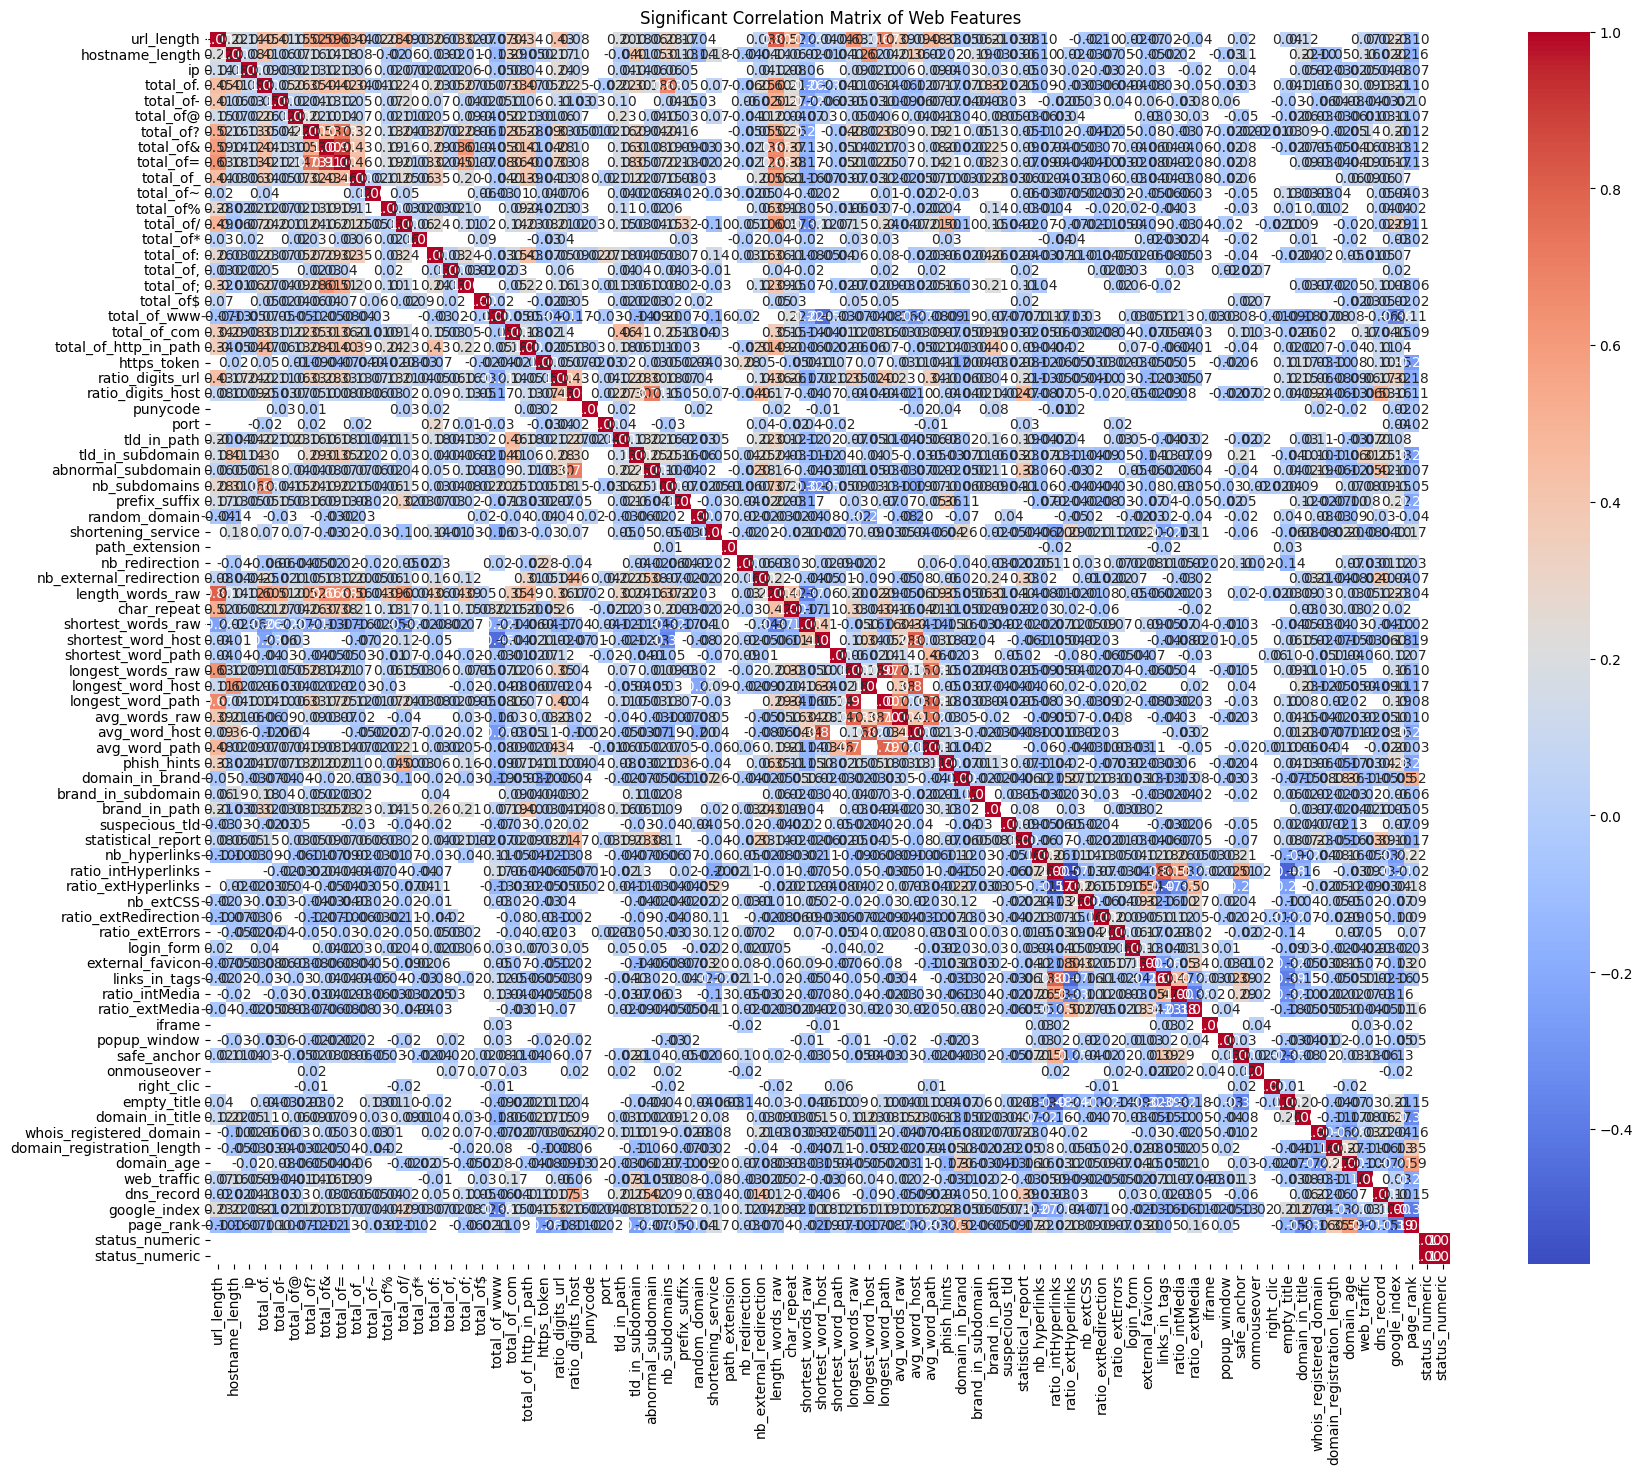

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Assuming 'ph' is your DataFrame and columns_for_correlation is already defined
ph['status_numeric'] = ph['status'].map({'phishing': 1, 'legitimate': 0})
columns_for_correlation.append('status_numeric')

# Select relevant data
data = ph[columns_for_correlation]

# Initialize a DataFrame to store the p-values and correlation coefficients
p_values = pd.DataFrame(index=columns_for_correlation, columns=columns_for_correlation)
correlation_matrix = pd.DataFrame(index=columns_for_correlation, columns=columns_for_correlation)

# Calculate the correlation matrix and the corresponding p-values
for col1 in columns_for_correlation:
    for col2 in columns_for_correlation:
        # Drop NA values for both columns to ensure equal length
        combined = data[[col1, col2]].dropna()
        if len(combined) > 1:  # Ensure there are enough data points to calculate correlation
            # Extract series and ensure they are 1D
            x = combined[col1].values.ravel()  # Use ravel to ensure 1D array
            y = combined[col2].values.ravel()  # Use ravel to ensure 1D array

            # Debug print to check shapes before calling pearsonr
            print(f"Shape of {col1}: {x.shape}, Shape of {col2}: {y.shape}")

            try:
                corr, p_value = pearsonr(x, y)
                correlation_matrix.loc[col1, col2] = corr
                p_values.loc[col1, col2] = p_value
            except Exception as e:
                print(f"Error processing {col1} vs {col2}: {e}")
                correlation_matrix.loc[col1, col2] = np.nan
                p_values.loc[col1, col2] = np.nan
        else:
            correlation_matrix.loc[col1, col2] = np.nan
            p_values.loc[col1, col2] = np.nan

# Convert the correlation matrix and p-values matrix to numeric
correlation_matrix = correlation_matrix.astype(float)
p_values = p_values.astype(float)

# Filter the correlation matrix to keep only statistically significant correlations (p < 0.05)
significant_correlation_matrix = correlation_matrix.where(p_values < 0.05)

# Plot the significant correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(significant_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=significant_correlation_matrix.isnull())
plt.title('Significant Correlation Matrix of Web Features')
plt.show()


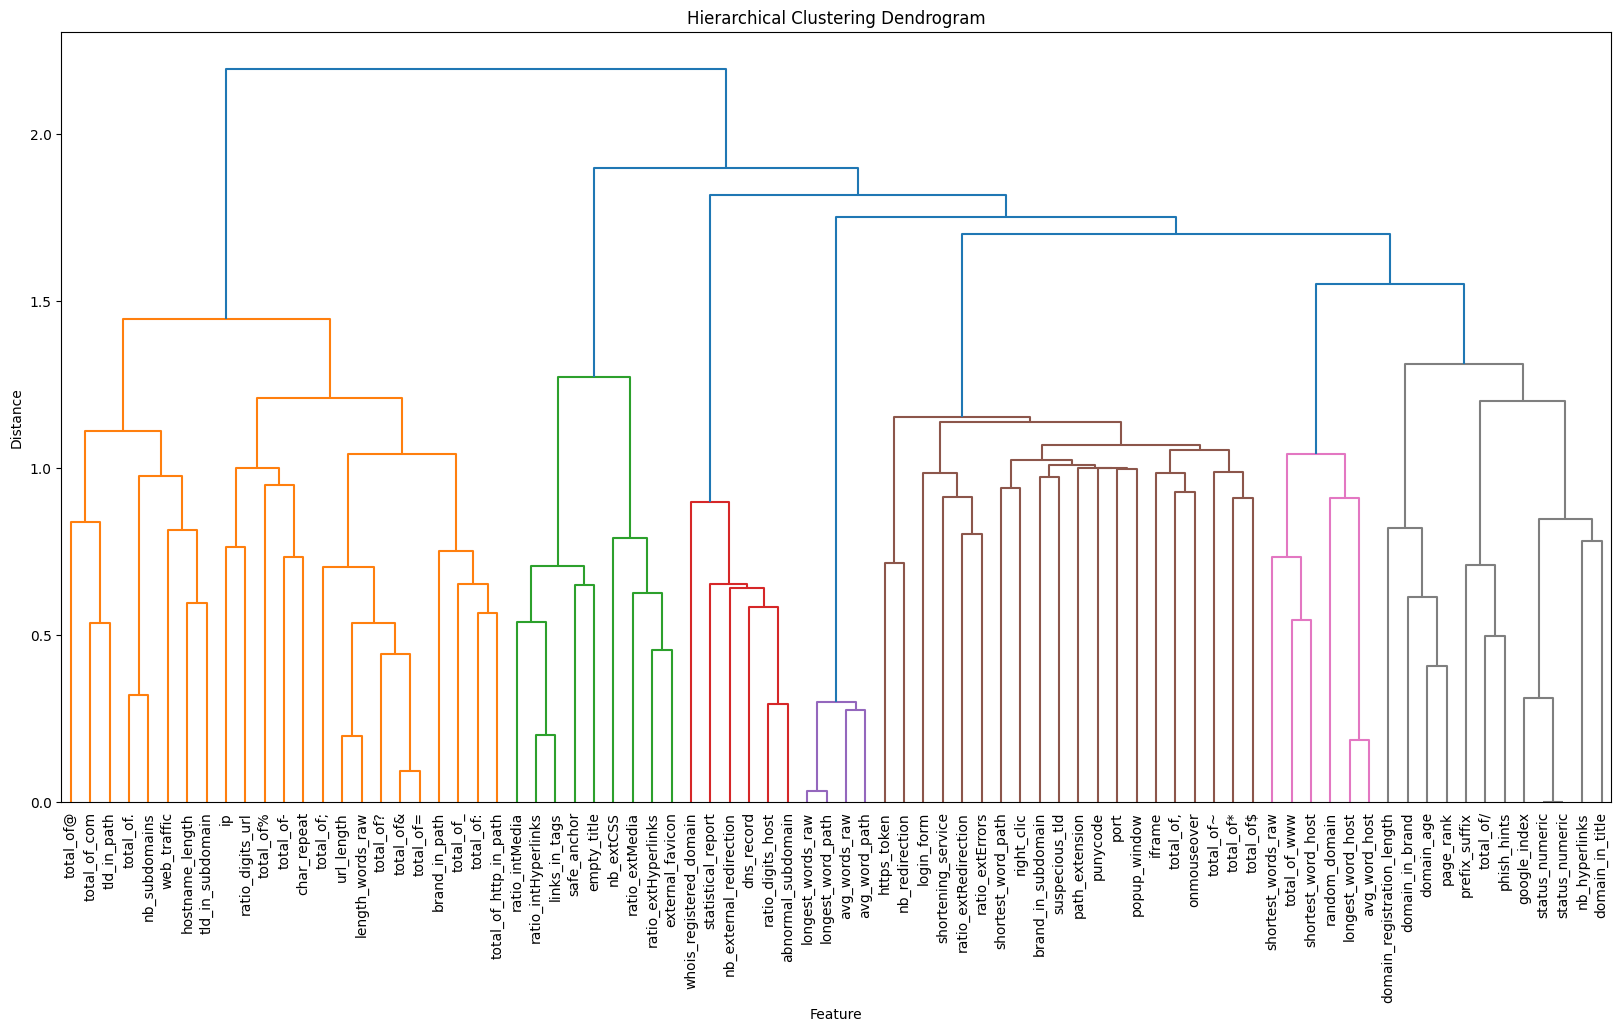

In [11]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Assuming 'ph' is your DataFrame and you've already computed 'correlation_matrix'
correlation_matrix = ph[columns_for_correlation].corr()

# Convert the correlation matrix to a distance matrix before performing hierarchical clustering
distance_matrix = 1 - np.abs(correlation_matrix)

# Perform hierarchical clustering
linkage = hierarchy.ward(squareform(distance_matrix))

# Plot the dendrogram
plt.figure(figsize=(20, 10))
dendrogram = hierarchy.dendrogram(linkage, labels=correlation_matrix.columns, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Feature')
plt.ylabel('Distance')
plt.show()


# Google Index//Page Rank

<ipython-input-12-c240099f6308>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='google_index', y='status_numeric', data=ph, ci=None)


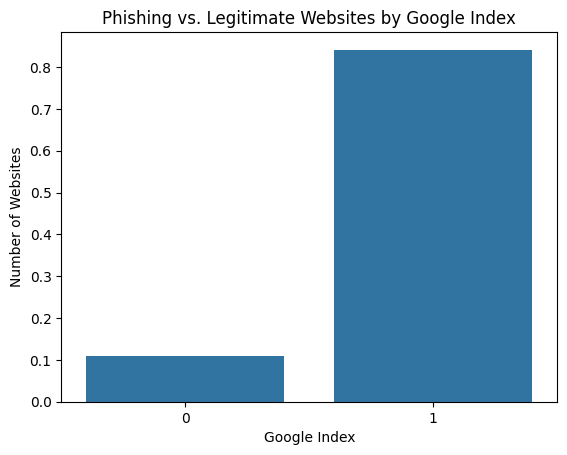

In [12]:
# prompt: how to make a chart for phishing vs legitimate based on the google_index variable

# Create a bar chart with separate bars for phishing and legitimate websites based on the 'google_index' variable
sns.barplot(x='google_index', y='status_numeric', data=ph, ci=None)
plt.title('Phishing vs. Legitimate Websites by Google Index')
plt.xlabel('Google Index')
plt.ylabel('Number of Websites')
plt.show()


# More Distribution Plots

In [13]:
nZ = pd.DataFrame(ph)

# Filter out zero values for a specific column
wt = 'web_traffic'
filtered_df = nZ[nZ[wt] != 0]

print("Filtered DataFrame:")
print(filtered_df)

Filtered DataFrame:
       Unnamed: 0                                                url  \
0               0     http://www.progarchives.com/album.asp?id=61737   
4               4                       https://www.velocidrone.com/   
5               5  https://support-appleld.com.secureupdate.duila...   
6               6  https://www.authpro.com/auth/ubabankng/?action...   
8               8                http://www.tutorialspoint.com/dbms/   
...           ...                                                ...   
19424       11423  http://www.dmega.co.kr/dmega/data/qna/sec/page...   
19425       11424  http://www.answers.com/Q/What_are_the_sizes_of...   
19426       11425      http://www.fontspace.com/category/blackletter   
19428       11427  https://www.facebook.com/Interactive-Televisio...   
19429       11428             http://www.mypublicdomainpictures.com/   

       url_length  hostname_length  ip  total_of.  total_of-  total_of@  \
0        0.020872               20   0  

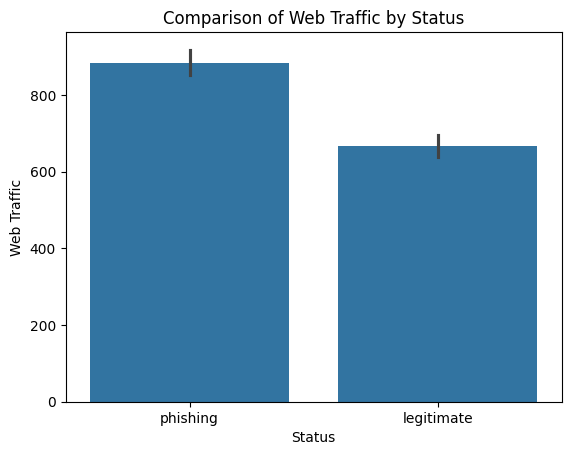

In [14]:
sns.barplot(x='status', y='web_traffic', data=filtered_df, estimator=sum)  # Use estimator='mean' for mean instead of sum
plt.title('Comparison of Web Traffic by Status')
plt.xlabel('Status')
plt.ylabel('Web Traffic')
plt.show()

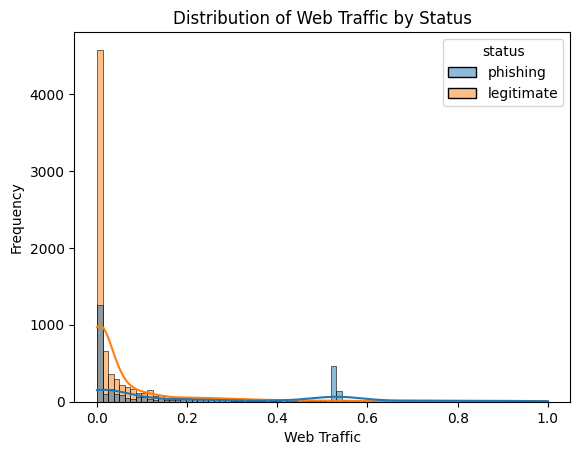

In [15]:
sns.histplot(data=filtered_df, x='web_traffic', hue='status', kde=True)
plt.title('Distribution of Web Traffic by Status')
plt.xlabel('Web Traffic')
plt.ylabel('Frequency')
plt.show()

In [16]:
webtrafficmean = np.mean(ph[wt])
print("Mean: ", webtrafficmean)

Mean:  0.0798208324423665


In [17]:
mean_traffic_by_status = ph.groupby('status')['web_traffic'].mean()

print("Mean web traffic by status:")
print(mean_traffic_by_status)


Mean web traffic by status:
status
legitimate    0.068589
phishing      0.091054
Name: web_traffic, dtype: float64


In [18]:
ph['keyword_login'] = ph['url'].apply(lambda x: 1 if 'login' in x.lower() else 0)


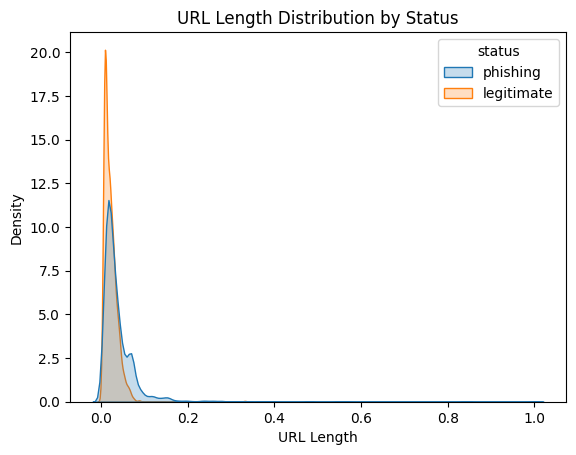

In [19]:

sns.kdeplot(data=ph, x='url_length', hue='status', fill=True)
plt.title('URL Length Distribution by Status')
plt.xlabel('URL Length')
plt.ylabel('Density')
plt.show()


In [20]:
from scipy.stats import chi2_contingency
import pandas as pd

# Cross-tabulation
cross_tab = pd.crosstab(ph['google_index'], ph['status'])
print(cross_tab)

# Chi-square test
chi2, p, dof, expected = chi2_contingency(cross_tab)
print(f'Chi-square test p-value: {p}')
#the null hypothesis is rejected, test is statistically significant

status        legitimate  phishing
google_index                      
0                   8069       986
1                   1647      8729
Chi-square test p-value: 0.0


In [21]:
from scipy.stats import ttest_ind

# Splitting the dataset
phishing = ph[ph['status'] == 'phishing']['url_length']
legitimate = ph[ph['status'] == 'legitimate']['url_length']

# Performing the T-test
t_stat, p_val = ttest_ind(phishing, legitimate)
print(f'T-test p-value: {p_val}')
#the url_length of phishing vs. legitimate sites is highly statistically significant.



T-test p-value: 4.3510105854835096e-262


In [22]:
from sklearn.model_selection import train_test_split
# Prepare the features and target variable
X = ph.drop(['status', 'status_encoded'], axis=1)  # Dropping non-feature columns
y = ph['status_encoded']  # Target variable

# Split the dataset into training and testing sets
# test_size=0.2 indicates that 20% of the data will be used for testing
# random_state ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Ranking Importance of Variables
Contributing to websites being either Phishing or Legittimate


**Gradient Boosting**

In [23]:
import xgboost as xgb
import matplotlib.pyplot as plt


In [24]:
model = xgb.XGBClassifier()

X_train.dtypes

Unnamed: 0           int64
url                 object
url_length         float64
hostname_length      int64
ip                   int64
                    ...   
dns_record           int64
google_index         int64
page_rank            int64
status_numeric       int64
keyword_login        int64
Length: 88, dtype: object

In [25]:
X_train = X_train.apply(pd.to_numeric, errors='coerce')

In [26]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [27]:

# Define the XGBoost model
model = xgb.XGBClassifier()

# Train the model
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

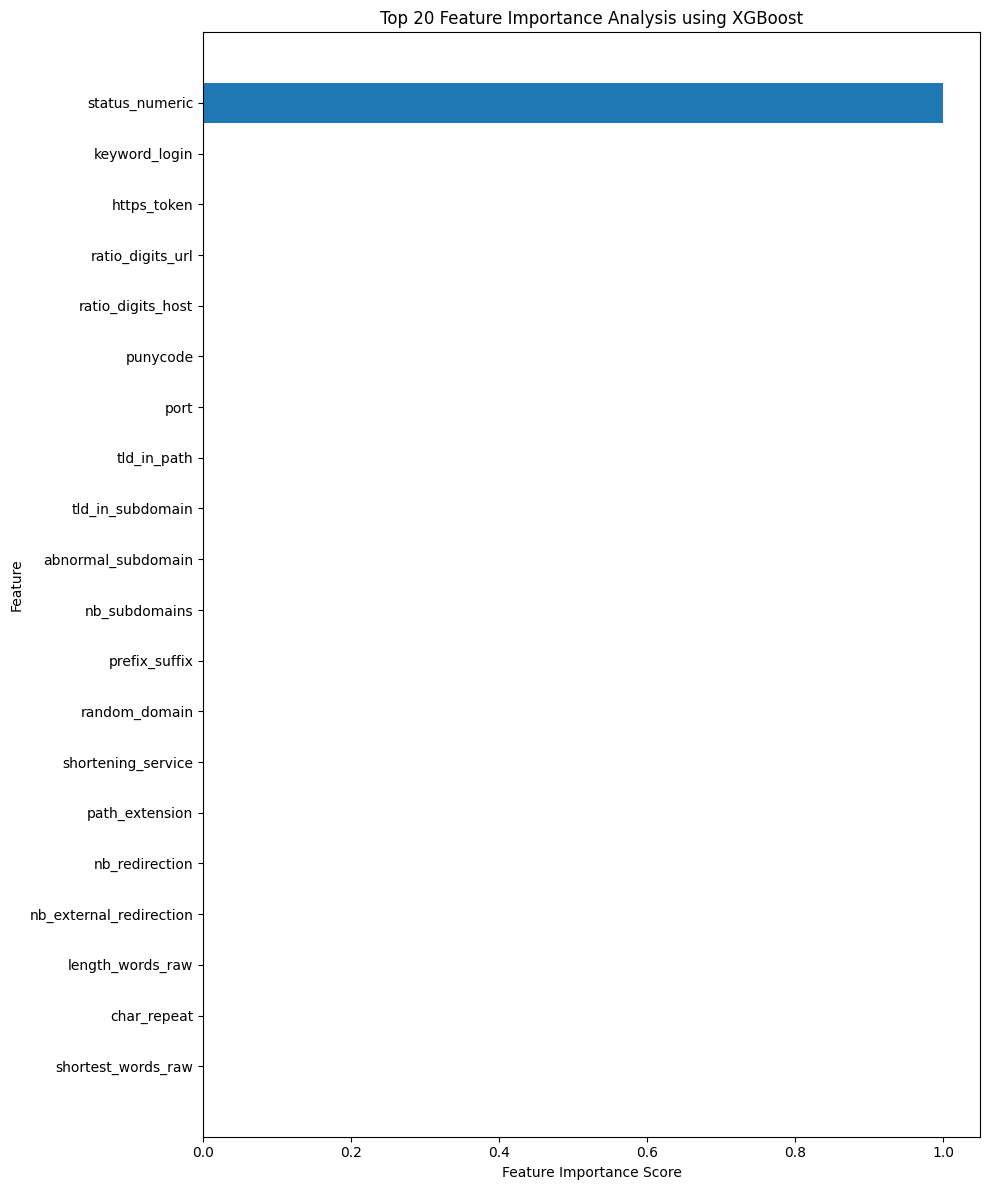

In [28]:
# Get feature importance scores
feature_importance = model.feature_importances_

# Sort feature importances
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_names = X_train.columns[sorted_indices]

# Choose how many top features to display
top_n = 20  # You can adjust this number
top_sorted_feature_names = sorted_feature_names[:top_n]
top_feature_importance = feature_importance[sorted_indices][:top_n]

# Plot feature importances
plt.figure(figsize=(10, 12))  # Increase figure size
plt.barh(top_sorted_feature_names[::-1], top_feature_importance[::-1])  # Reverse to have the highest at the top
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance Analysis using XGBoost')
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()


In [29]:
print(y_train.unique())

[0 1]


In [30]:
y_train = y_train.replace({'legitimate': 0, 'phishing': 1})

In [31]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)

<ipython-input-32-bca19ef426d5>:8: DtypeWarning: Columns (78) have mixed types. Specify dtype option on import or set low_memory=False.
  phishing_data = pd.read_csv(file_path)


NaNs per column after coercion: Unnamed: 0         0
url_length         0
hostname_length    0
ip                 0
total_of.          0
                  ..
domain_age         0
web_traffic        0
dns_record         0
google_index       0
page_rank          0
Length: 85, dtype: int64
Columns dropped (zero variance): ['ratio_nullHyperlinks', 'ratio_intRedirection', 'ratio_intErrors', 'submit_email', 'sfh']
Remaining features: 80
Top feature importances: [('google_index', 0.5366645), ('total_of_www', 0.034909975), ('page_rank', 0.032817166), ('total_of?', 0.031655744), ('nb_hyperlinks', 0.026839303), ('ratio_digits_host', 0.02229879), ('phish_hints', 0.02168303), ('suspecious_tld', 0.019891333), ('total_of:', 0.01880727), ('total_of_http_in_path', 0.015125664), ('domain_in_brand', 0.014275822), ('total_of=', 0.011253371), ('total_of-', 0.009464157), ('web_traffic', 0.0094039105), ('length_words_raw', 0.009289093), ('shortest_word_path', 0.008952187), ('shortening_service', 0.008385519

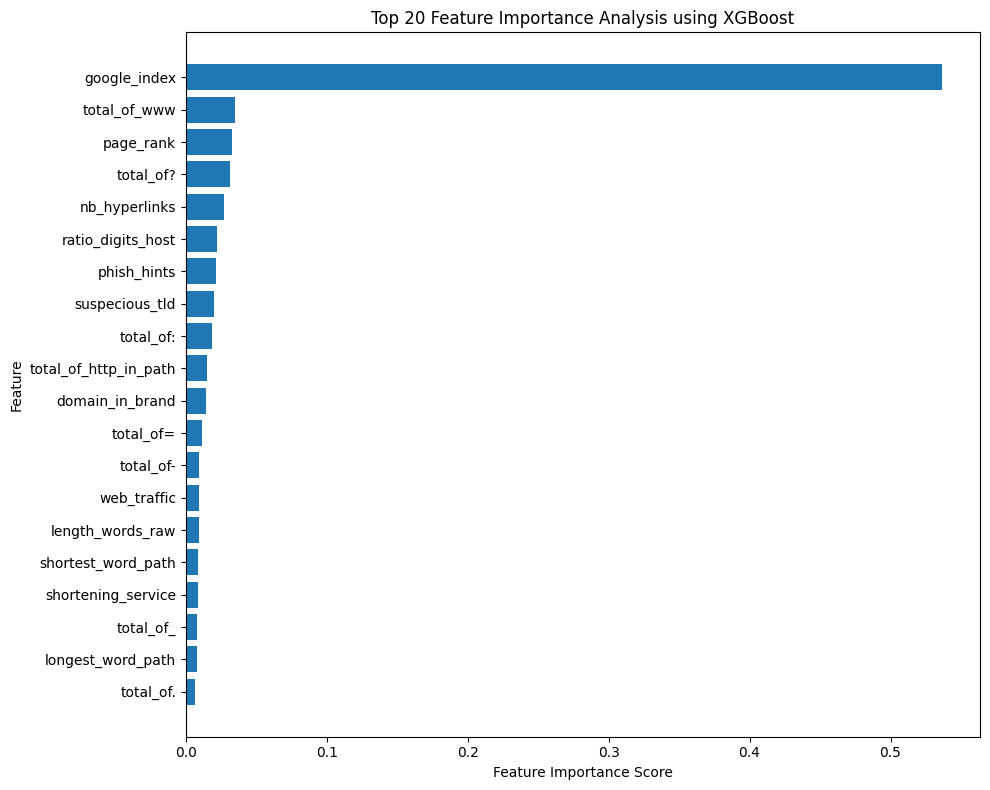

In [32]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = '/content/dataset_link_phishing.csv'
phishing_data = pd.read_csv(file_path)

# Assuming ph is defined and loaded properly
X_train = phishing_data.drop(columns=['status', 'url'])  # Ensure 'status' is not included
y_train = phishing_data['status'].map({'legitimate': 0, 'phishing': 1})

# Convert all features to numeric, coercing errors for any non-numeric data
X_train = X_train.apply(pd.to_numeric, errors='coerce')
print("NaNs per column after coercion:", X_train.isna().sum())

# Fill NaN values
X_train.fillna(X_train.mean(), inplace=True)

# Drop columns with zero variance
variances = X_train.var()
columns_dropped = variances[variances == 0].index
X_train = X_train.loc[:, variances != 0]
print(f"Columns dropped (zero variance): {list(columns_dropped)}")
print(f"Remaining features: {X_train.shape[1]}")

# Define and train the XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Get and sort feature importance
feature_importance = model.feature_importances_
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_names = X_train.columns[sorted_indices]
top_n = 20
top_sorted_feature_names = sorted_feature_names[:top_n]
top_feature_importance = feature_importance[sorted_indices][:top_n]

print("Top feature importances:", list(zip(top_sorted_feature_names, top_feature_importance)))

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_sorted_feature_names[::-1], top_feature_importance[::-1])
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance Analysis using XGBoost')
plt.tight_layout()
plt.show()


**Random** **Forest Classifier (for feature importance)**

<ipython-input-33-ef6df5ece830>:8: DtypeWarning: Columns (78) have mixed types. Specify dtype option on import or set low_memory=False.
  phishing_data = pd.read_csv(file_path)


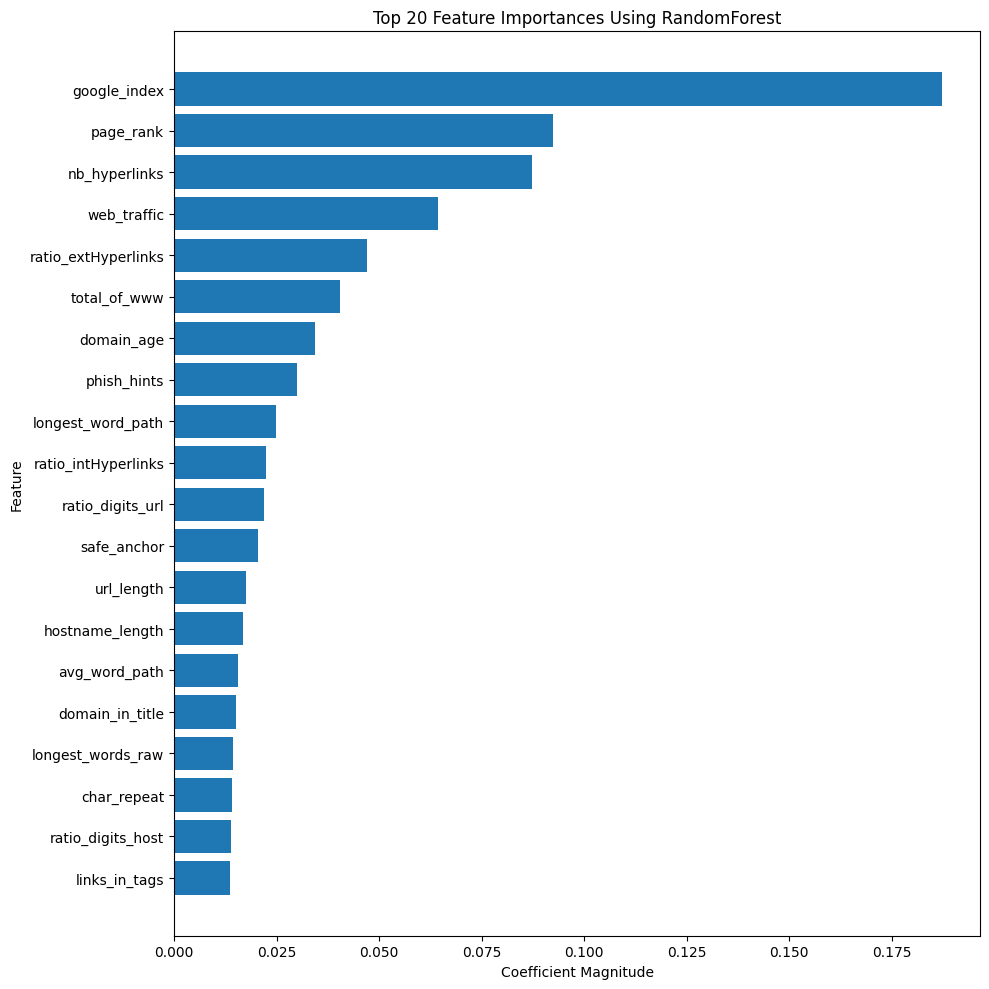

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Load the dataset
file_path = '/content/dataset_link_phishing.csv'
phishing_data = pd.read_csv(file_path)

# Handle potential mixed-type issues
phishing_data.iloc[:, 78] = pd.to_numeric(phishing_data.iloc[:, 78], errors='coerce')

# Convert the 'status' column into a binary format where 'phishing' is 1 and 'legitimate' is 0
phishing_data['status'] = phishing_data['status'].map({'phishing': 1, 'legitimate': 0})

# Drop any remaining missing values to clean up the dataset
phishing_data_clean = phishing_data.dropna()

# Separate features and the target variable
y_train = phishing_data_clean['status']
X_train = phishing_data_clean.drop(columns=['status', 'url'])  # Exclude the non-numeric and target column

# Initialize and train the RandomForest classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Extract feature names
feature_names = X_train.columns

# Get the feature importances, sort them, and create a bar chart
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
sorted_feature_names = feature_names[indices]
top_features = sorted_feature_names[:20]  # Select the top 20 features
top_importances = importances[indices][:20]

plt.figure(figsize=(10, 10))
plt.barh(top_features[::-1], top_importances[::-1])  # Reverse the order to have the most important at the top
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances Using RandomForest')
plt.tight_layout()
plt.show()




```
# Checking RMSE and MAE
```



**Correlation Analysis for variables**

```
# Correlation Analysis
```



In [35]:
feature_importances = X_train.columns
top_n=20
top_feature_importances = feature_importances[sorted_indices][:top_n]

In [36]:
# Sort feature importances and get the sorted feature names
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = [f'Feature {i}' for i in sorted_indices]

# Determine the number of features to display
n_features_to_display = 20  # Adjust this to display more or fewer features

# Increase the figure size for better readability
plt.figure(figsize=(20, 20))  # Width, Height in inches



<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

In [37]:
print(f"Length of top_feature_importances: {len(top_feature_importances)}")
print(f"Length of sorted_feature_names: {len(sorted_feature_names)}")

Length of top_feature_importances: 20
Length of sorted_feature_names: 85


In [38]:
if n_features_to_display > len(top_feature_importances) or n_features_to_display > len(sorted_feature_names):
    raise ValueError("n_features_to_display should not exceed the lengths of top_feature_importances and sorted_feature_names.")


In [39]:
print("Shape of feature_importances:", feature_importances.shape)
print("Shape of sorted_feature_names:", len(sorted_feature_names))
print("Shape of sorted_indices:", sorted_indices.shape)

Shape of feature_importances: (85,)
Shape of sorted_feature_names: 85
Shape of sorted_indices: (85,)


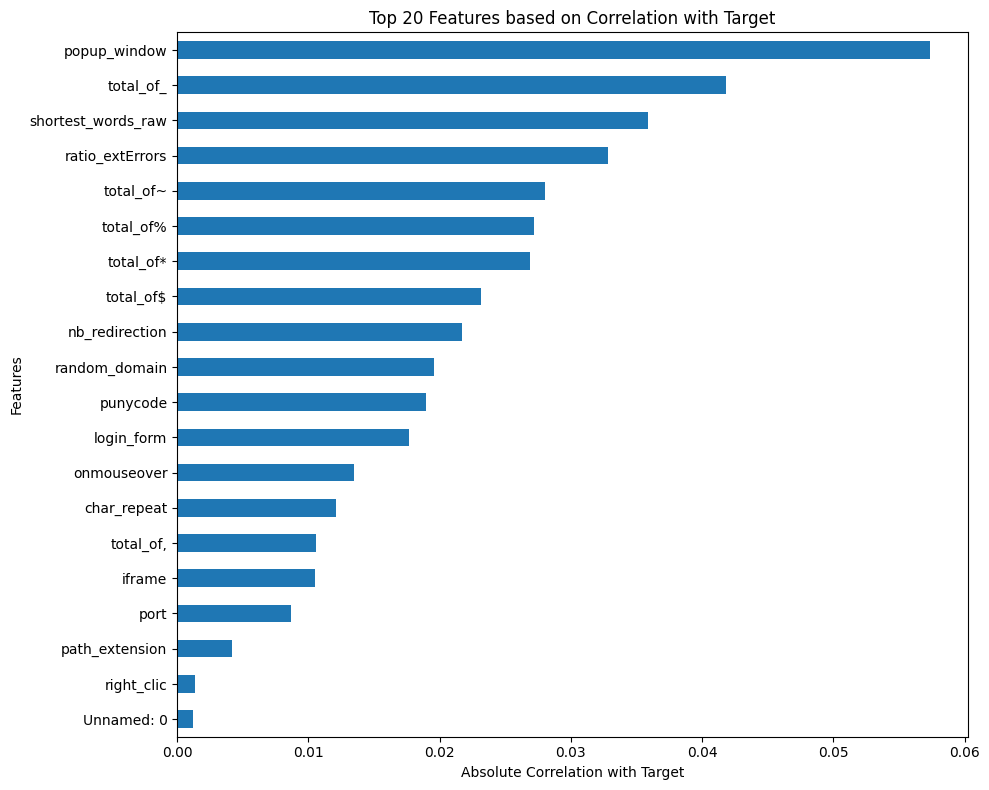

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Load the dataset
file_path = '/content/dataset_link_phishing.csv'
phishing_data = pd.read_csv(file_path, low_memory=False)

# Handle mixed-type issues by converting them to numeric, errors are coerced to NaN
phishing_data.iloc[:, 78] = pd.to_numeric(phishing_data.iloc[:, 78], errors='coerce')

# Convert categorical 'status' column into numeric
phishing_data['status'] = phishing_data['status'].map({'phishing': 1, 'legitimate': 0})

# Drop columns that won't be used as features (if any)
phishing_data.drop(columns=['url'], inplace=True)  # Assuming 'url' is not a feature

# Encode categorical data
for col in phishing_data.select_dtypes(include=['object']).columns:
    phishing_data[col] = LabelEncoder().fit_transform(phishing_data[col].astype(str))

# Impute missing values
imputer = SimpleImputer(strategy='mean')
phishing_data = pd.DataFrame(imputer.fit_transform(phishing_data), columns=phishing_data.columns)

# Calculate the correlation matrix
corr_matrix = phishing_data.corr()

# Extract correlation with the target variable 'status'
target_corr = corr_matrix['status'].drop('status')  # Remove self-correlation

# Sort the values based on the magnitude (absolute value)
sorted_corr = target_corr.abs().sort_values(ascending=True)

# Plot the correlations as a bar chart for the top 20 features
plt.figure(figsize=(10, 8))
sorted_corr[:20].plot(kind='barh')  # Limit to top 20 and use barh for horizontal bar chart
plt.title('Top 20 Features based on Correlation with Target')
plt.xlabel('Absolute Correlation with Target')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


Logistic Regression


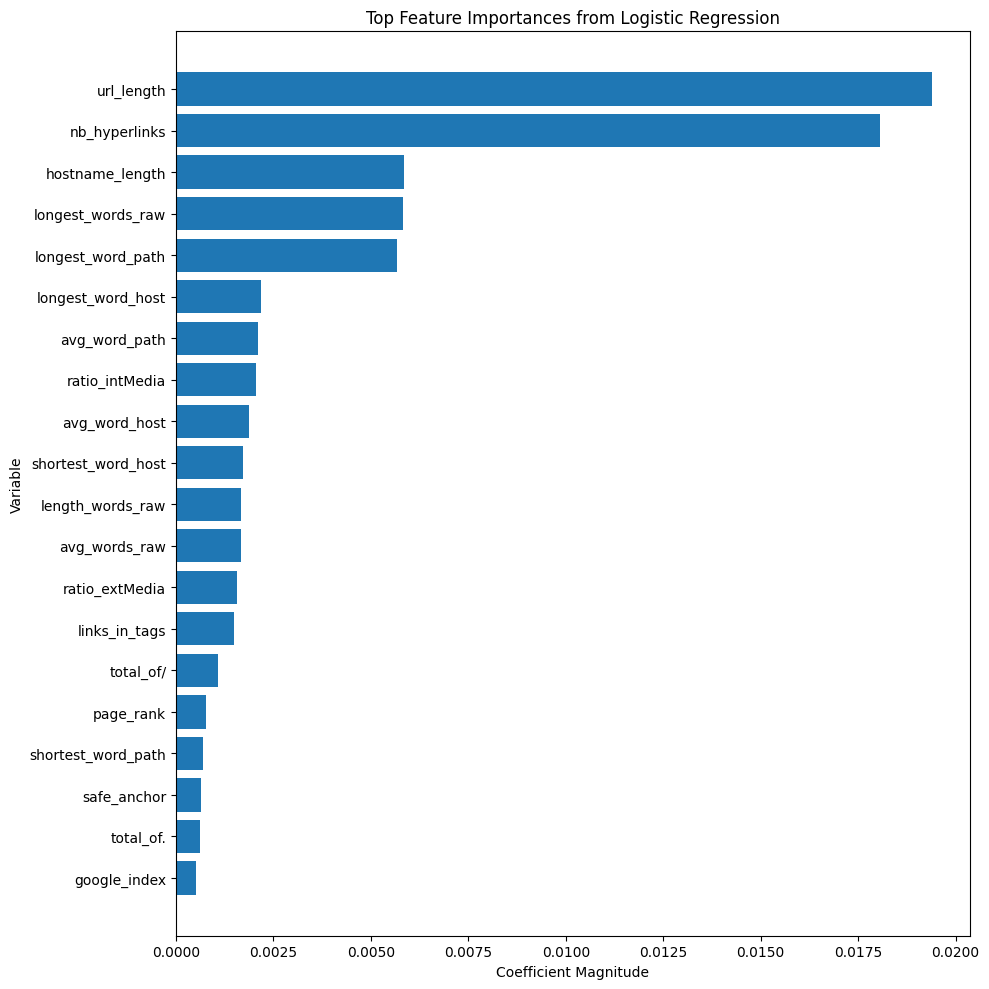

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = '/content/dataset_link_phishing.csv'
phishing_data = pd.read_csv(file_path, low_memory=False)

#Status variable
y_train = phishing_data['status'].map({'legitimate': 0, 'phishing': 1})

#Dropping unnecessary Columns
X = phishing_data.drop(columns=['status', 'url'])  # Drop non-feature columns
X = X.apply(lambda col: LabelEncoder().fit_transform(col.astype(str)) if col.dtype == 'object' else col)

# Fill NaN values with the mean of each column
X.fillna(X.mean(), inplace=True)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Extract the absolute values of the coefficients
feature_importances = np.abs(clf.coef_[0])
feature_names = X_train.columns

# Sort the features by their importance
sorted_idx = np.argsort(feature_importances)
num_features = len(feature_importances)
top_n = min(20, num_features)  # Choose the top n features

# Get the names and importance values of the top features
sorted_feature_names = np.array(feature_names)[sorted_idx][-top_n:]
sorted_importances = feature_importances[sorted_idx][-top_n:]

plt.figure(figsize=(10, 10))

# Create horizontal bar plot
plt.barh(sorted_feature_names, sorted_importances)

# Set labels and title
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Variable')
plt.title('Top Feature Importances from Logistic Regression')

# Improve layout
plt.tight_layout()

plt.show()


In [42]:
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107720 sha256=89ce114a2959cdfd4d699eb733ef92c02eb369d9e103c594980ff85a0024b82b
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [43]:
import eli5
from eli5.sklearn import PermutationImportance

In [44]:
perm = PermutationImportance(clf, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

# Machine Learning Modeling

**Random Forest Prediction**

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [50]:
ph.columns

Index(['Unnamed: 0', 'url', 'url_length', 'hostname_length', 'ip', 'total_of.',
       'total_of-', 'total_of@', 'total_of?', 'total_of&', 'total_of=',
       'total_of_', 'total_of~', 'total_of%', 'total_of/', 'total_of*',
       'total_of:', 'total_of,', 'total_of;', 'total_of$', 'total_of_www',
       'total_of_com', 'total_of_http_in_path', 'https_token',
       'ratio_digits_url', 'ratio_digits_host', 'punycode', 'port',
       'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain',
       'nb_subdomains', 'prefix_suffix', 'random_domain', 'shortening_service',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       'statist

In [54]:
file_path = '/content/dataset_link_phishing.csv'
phishing_data = pd.read_csv(file_path, low_memory=False)
y_train = phishing_data['status'].map({'legitimate': 0, 'phishing': 1})
#Features selected from feature importance models
phFeatures = ['google_index', 'web_traffic', 'nb_hyperlinks', 'domain_age', 'url_length', 'popup_window']
X = phishing_data[phFeatures]

X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size=0.2, random_state=42)

In [55]:
rf_mod = RandomForestClassifier(n_estimators=100, random_state=42)

In [57]:
rf_mod.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [59]:
y_pred = rf_mod.predict(X_test)

In [60]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

Accuracy:  0.979933110367893


In [61]:
print(y_pred)

[0 0 1 ... 0 0 0]


In [ ]:
plt.scatter(,y_pred)